In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

2023-08-13 23:23:19.931532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

In [3]:
def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

In [4]:
#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [5]:
#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model


In [6]:
from keras.models import Model
from keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, GlobalAveragePooling2D, Dense, Flatten

def create_disc(disc_ip):
    df = 64

    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)

    d8_5 = GlobalAveragePooling2D()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)


In [7]:
from keras.applications import VGG19
def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)


In [8]:
#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [9]:
input_shape = (None, None, 3)

g_ip = Input(shape=input_shape)
d_ip = Input(shape=input_shape)

In [10]:
generator = create_gen(g_ip, num_res_block = 16)
generator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
generator.summary()

2023-08-13 23:23:24.253881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   15616       ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 p_re_lu (PReLU)                (None, None, None,   64          ['conv2d[0][0]']                 
                                64)                                                           

                                                                                                  
 conv2d_9 (Conv2D)              (None, None, None,   36928       ['add_3[0][0]']                  
                                64)                                                               
                                                                                                  
 batch_normalization_8 (BatchNo  (None, None, None,   256        ['conv2d_9[0][0]']               
 rmalization)                   64)                                                               
                                                                                                  
 p_re_lu_5 (PReLU)              (None, None, None,   64          ['batch_normalization_8[0][0]']  
                                64)                                                               
                                                                                                  
 conv2d_10

                                64)                                                               
                                                                                                  
 batch_normalization_17 (BatchN  (None, None, None,   256        ['conv2d_18[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 add_8 (Add)                    (None, None, None,   0           ['add_7[0][0]',                  
                                64)                               'batch_normalization_17[0][0]'] 
                                                                                                  
 conv2d_19 (Conv2D)             (None, None, None,   36928       ['add_8[0][0]']                  
                                64)                                                               
          

 batch_normalization_26 (BatchN  (None, None, None,   256        ['conv2d_27[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 p_re_lu_14 (PReLU)             (None, None, None,   64          ['batch_normalization_26[0][0]'] 
                                64)                                                               
                                                                                                  
 conv2d_28 (Conv2D)             (None, None, None,   36928       ['p_re_lu_14[0][0]']             
                                64)                                                               
                                                                                                  
 batch_normalization_27 (BatchN  (None, None, None,   256        ['conv2d_28[0][0]']              
 ormalizat

__________________________________________________________________________________________________


In [11]:
discriminator = create_disc(d_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d_37 (Conv2D)          (None, None, None, 64)    1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, None, None, 64)    0         
                                                                 
 conv2d_38 (Conv2D)          (None, None, None, 64)    36928     
                                                                 
 batch_normalization_33 (Bat  (None, None, None, 64)   256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, None, None, 64)    0         
                                                           

In [12]:
vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [13]:
gan_model = create_comb(generator, discriminator, vgg, g_ip, d_ip)

In [14]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 model (Functional)             (None, None, None,   2044291     ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                        

In [15]:
import pickle
generator.load_weights('g_w_15.h5')
generator.make_train_function()
with open('g_o_15.pkl', 'rb') as f:
    weight_values = pickle.load(f)
generator.optimizer.set_weights(weight_values)

In [16]:
import pickle

# Save optimizer weights
optimizer_weights = discriminator.optimizer.get_weights()
with open('d_o_w.pkl', 'wb') as f:
    pickle.dump(optimizer_weights, f)


In [17]:
# Load optimizer weights
with open('d_o_w.pkl', 'rb') as f:
    optimizer_weights = pickle.load(f)

# Set optimizer weights
discriminator.optimizer.set_weights(optimizer_weights)


In [18]:
n=800
lr_list = os.listdir("/Users/akshat/GAN/lr_images/")[2400:2400+n]
lr_images = []
for img in lr_list:
    img_lr = cv2.imread("/Users/akshat/GAN/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir("/Users/akshat/GAN/hr_images/")[2400:2400+n]

hr_images = []
for img in hr_list:
    img_hr = cv2.imread("/Users/akshat/GAN/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

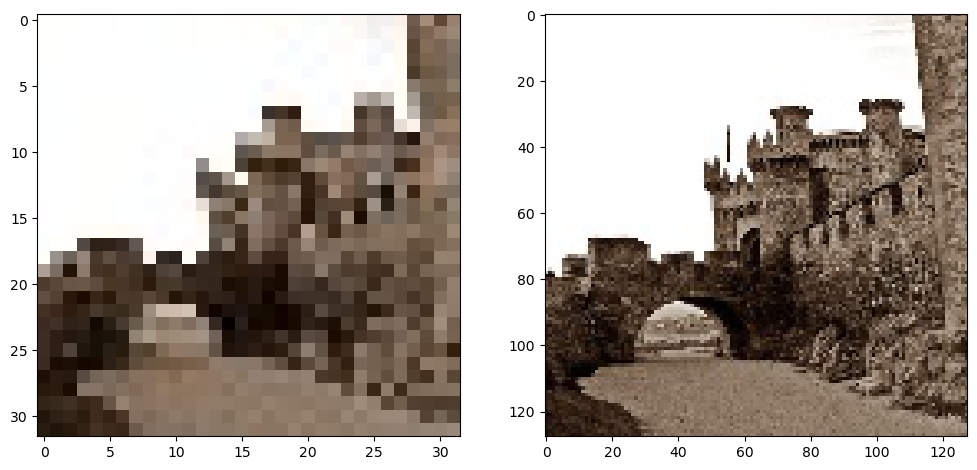

In [19]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

In [20]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

In [21]:
#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)

In [29]:
#Create a list of images for LR and HR in batches from which a batch of images would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])
epochs = 10

In [23]:
import keras.backend as K
import pickle

for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("g_16.h5",include_optimizer=True)
        #discriminator.save("d_15.h5",include_optimizer=True)
        
        generator.save_weights('g_w_15.h5')
        discriminator.save_weights('d_w_15.h5')
        
        symbolic_weights = getattr(generator.optimizer, 'weights')
        weight_values = K.batch_get_value(symbolic_weights)
        with open('g_o_15.pkl', 'wb') as f:
            pickle.dump(weight_values, f)
        
        symbolic_weights = getattr(discriminator.optimizer, 'weights')
        weight_values = K.batch_get_value(symbolic_weights)
        with open('d_o_15.pkl', 'wb') as f:
            pickle.dump(weight_values, f)

  0%|                                                    | 0/13 [00:00<?, ?it/s]

1/1 [==============================] - 0s 127ms/step


  8%|███▍                                        | 1/13 [00:06<01:13,  6.12s/it]

1/1 [==============================] - 0s 70ms/step


 15%|██████▊                                     | 2/13 [00:07<00:36,  3.34s/it]

1/1 [==============================] - 0s 68ms/step


 23%|██████████▏                                 | 3/13 [00:08<00:24,  2.43s/it]

1/1 [==============================] - 0s 66ms/step


 31%|█████████████▌                              | 4/13 [00:10<00:17,  1.99s/it]

1/1 [==============================] - 0s 72ms/step


 38%|████████████████▉                           | 5/13 [00:11<00:14,  1.76s/it]

1/1 [==============================] - 0s 67ms/step


 46%|████████████████████▎                       | 6/13 [00:12<00:11,  1.64s/it]

1/1 [==============================] - 0s 66ms/step


 54%|███████████████████████▋                    | 7/13 [00:14<00:09,  1.57s/it]

1/1 [==============================] - 0s 66ms/step


 62%|███████████████████████████                 | 8/13 [00:15<00:07,  1.50s/it]

1/1 [==============================] - 0s 66ms/step


 69%|██████████████████████████████▍             | 9/13 [00:17<00:05,  1.45s/it]

1/1 [==============================] - 0s 67ms/step


 77%|█████████████████████████████████          | 10/13 [00:18<00:04,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 85%|████████████████████████████████████▍      | 11/13 [00:19<00:02,  1.39s/it]

1/1 [==============================] - 0s 67ms/step


 92%|███████████████████████████████████████▋   | 12/13 [00:21<00:01,  1.38s/it]

1/1 [==============================] - 0s 68ms/step


100%|███████████████████████████████████████████| 13/13 [00:22<00:00,  1.72s/it]


epoch: 1 g_loss: 78.03396811852089 d_loss: [0.9111065  0.46153846]


  0%|                                                    | 0/13 [00:00<?, ?it/s]

1/1 [==============================] - 0s 68ms/step


  8%|███▍                                        | 1/13 [00:01<00:15,  1.32s/it]

1/1 [==============================] - 0s 67ms/step


 15%|██████▊                                     | 2/13 [00:02<00:14,  1.32s/it]

1/1 [==============================] - 0s 67ms/step


 23%|██████████▏                                 | 3/13 [00:03<00:13,  1.33s/it]

1/1 [==============================] - 0s 66ms/step


 31%|█████████████▌                              | 4/13 [00:05<00:11,  1.33s/it]

1/1 [==============================] - 0s 66ms/step


 38%|████████████████▉                           | 5/13 [00:06<00:10,  1.33s/it]

1/1 [==============================] - 0s 66ms/step


 46%|████████████████████▎                       | 6/13 [00:08<00:09,  1.35s/it]

1/1 [==============================] - 0s 67ms/step


 54%|███████████████████████▋                    | 7/13 [00:09<00:08,  1.34s/it]

1/1 [==============================] - 0s 66ms/step


 62%|███████████████████████████                 | 8/13 [00:10<00:06,  1.35s/it]

1/1 [==============================] - 0s 67ms/step


 69%|██████████████████████████████▍             | 9/13 [00:12<00:05,  1.37s/it]

1/1 [==============================] - 0s 66ms/step


 77%|█████████████████████████████████          | 10/13 [00:13<00:04,  1.40s/it]

1/1 [==============================] - 0s 73ms/step


 85%|████████████████████████████████████▍      | 11/13 [00:15<00:02,  1.43s/it]

1/1 [==============================] - 0s 66ms/step


 92%|███████████████████████████████████████▋   | 12/13 [00:16<00:01,  1.41s/it]

1/1 [==============================] - 0s 71ms/step


100%|███████████████████████████████████████████| 13/13 [00:18<00:00,  1.41s/it]


epoch: 2 g_loss: 67.32778813288762 d_loss: [0.73262682 0.11538462]


  0%|                                                    | 0/13 [00:00<?, ?it/s]

1/1 [==============================] - 0s 76ms/step


  8%|███▍                                        | 1/13 [00:01<00:17,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 15%|██████▊                                     | 2/13 [00:02<00:15,  1.39s/it]

1/1 [==============================] - 0s 65ms/step


 23%|██████████▏                                 | 3/13 [00:04<00:14,  1.48s/it]

1/1 [==============================] - 0s 140ms/step


 31%|█████████████▌                              | 4/13 [00:06<00:17,  1.92s/it]

1/1 [==============================] - 0s 75ms/step


 38%|████████████████▉                           | 5/13 [00:08<00:14,  1.76s/it]

1/1 [==============================] - 0s 66ms/step


 46%|████████████████████▎                       | 6/13 [00:09<00:11,  1.62s/it]

1/1 [==============================] - 0s 67ms/step


 54%|███████████████████████▋                    | 7/13 [00:11<00:09,  1.53s/it]

1/1 [==============================] - 0s 68ms/step


 62%|███████████████████████████                 | 8/13 [00:12<00:07,  1.46s/it]

1/1 [==============================] - 0s 68ms/step


 69%|██████████████████████████████▍             | 9/13 [00:13<00:05,  1.42s/it]

1/1 [==============================] - 0s 68ms/step


 77%|█████████████████████████████████          | 10/13 [00:15<00:04,  1.41s/it]

1/1 [==============================] - 0s 67ms/step


 85%|████████████████████████████████████▍      | 11/13 [00:16<00:02,  1.38s/it]

1/1 [==============================] - 0s 67ms/step


 92%|███████████████████████████████████████▋   | 12/13 [00:17<00:01,  1.37s/it]

1/1 [==============================] - 0s 66ms/step


100%|███████████████████████████████████████████| 13/13 [00:19<00:00,  1.49s/it]


epoch: 3 g_loss: 41.713020911583534 d_loss: [0.7182233  0.19230769]


  0%|                                                    | 0/13 [00:00<?, ?it/s]

1/1 [==============================] - 0s 72ms/step


  8%|███▍                                        | 1/13 [00:02<00:24,  2.01s/it]

1/1 [==============================] - 0s 70ms/step


 15%|██████▊                                     | 2/13 [00:03<00:18,  1.66s/it]

1/1 [==============================] - 0s 66ms/step


 23%|██████████▏                                 | 3/13 [00:04<00:15,  1.54s/it]

1/1 [==============================] - 0s 67ms/step


 31%|█████████████▌                              | 4/13 [00:06<00:13,  1.47s/it]

1/1 [==============================] - 0s 67ms/step


 38%|████████████████▉                           | 5/13 [00:07<00:11,  1.41s/it]

1/1 [==============================] - 0s 65ms/step


 46%|████████████████████▎                       | 6/13 [00:08<00:09,  1.39s/it]

1/1 [==============================] - 0s 67ms/step


 54%|███████████████████████▋                    | 7/13 [00:10<00:08,  1.38s/it]

1/1 [==============================] - 0s 66ms/step


 62%|███████████████████████████                 | 8/13 [00:11<00:06,  1.37s/it]

1/1 [==============================] - 0s 66ms/step


 69%|██████████████████████████████▍             | 9/13 [00:12<00:05,  1.36s/it]

1/1 [==============================] - 0s 68ms/step


 77%|█████████████████████████████████          | 10/13 [00:14<00:04,  1.36s/it]

1/1 [==============================] - 0s 67ms/step


 85%|████████████████████████████████████▍      | 11/13 [00:15<00:02,  1.36s/it]

1/1 [==============================] - 0s 66ms/step


 92%|███████████████████████████████████████▋   | 12/13 [00:16<00:01,  1.35s/it]

1/1 [==============================] - 0s 66ms/step


100%|███████████████████████████████████████████| 13/13 [00:18<00:00,  1.41s/it]


epoch: 4 g_loss: 34.80024095681998 d_loss: [0.71780617 0.30769231]


  0%|                                                    | 0/13 [00:00<?, ?it/s]

1/1 [==============================] - 0s 67ms/step


  8%|███▍                                        | 1/13 [00:01<00:16,  1.34s/it]

1/1 [==============================] - 0s 68ms/step


 15%|██████▊                                     | 2/13 [00:02<00:14,  1.34s/it]

1/1 [==============================] - 0s 67ms/step


 23%|██████████▏                                 | 3/13 [00:04<00:13,  1.34s/it]

1/1 [==============================] - 0s 69ms/step


 31%|█████████████▌                              | 4/13 [00:05<00:12,  1.34s/it]

1/1 [==============================] - 0s 66ms/step


 38%|████████████████▉                           | 5/13 [00:06<00:10,  1.34s/it]

1/1 [==============================] - 0s 66ms/step


 46%|████████████████████▎                       | 6/13 [00:08<00:09,  1.34s/it]

1/1 [==============================] - 0s 67ms/step


 54%|███████████████████████▋                    | 7/13 [00:09<00:07,  1.33s/it]

1/1 [==============================] - 0s 67ms/step


 62%|███████████████████████████                 | 8/13 [00:10<00:06,  1.33s/it]

1/1 [==============================] - 0s 67ms/step


 69%|██████████████████████████████▍             | 9/13 [00:12<00:05,  1.33s/it]

1/1 [==============================] - 0s 67ms/step


 77%|█████████████████████████████████          | 10/13 [00:13<00:03,  1.33s/it]

1/1 [==============================] - 0s 67ms/step


 85%|████████████████████████████████████▍      | 11/13 [00:14<00:02,  1.33s/it]

1/1 [==============================] - 0s 68ms/step


 92%|███████████████████████████████████████▋   | 12/13 [00:16<00:01,  1.36s/it]

1/1 [==============================] - 0s 66ms/step


100%|███████████████████████████████████████████| 13/13 [00:17<00:00,  1.34s/it]


epoch: 5 g_loss: 30.461093755868767 d_loss: [0.71308173 0.42307692]


  0%|                                                    | 0/13 [00:00<?, ?it/s]

1/1 [==============================] - 0s 68ms/step


  8%|███▍                                        | 1/13 [00:01<00:16,  1.34s/it]

1/1 [==============================] - 0s 66ms/step


 15%|██████▊                                     | 2/13 [00:02<00:15,  1.38s/it]

1/1 [==============================] - 0s 66ms/step


 23%|██████████▏                                 | 3/13 [00:04<00:13,  1.36s/it]

1/1 [==============================] - 0s 67ms/step


 31%|█████████████▌                              | 4/13 [00:05<00:12,  1.36s/it]

1/1 [==============================] - 0s 67ms/step


 38%|████████████████▉                           | 5/13 [00:06<00:10,  1.35s/it]

1/1 [==============================] - 0s 67ms/step


 46%|████████████████████▎                       | 6/13 [00:08<00:09,  1.34s/it]

1/1 [==============================] - 0s 65ms/step


 54%|███████████████████████▋                    | 7/13 [00:09<00:08,  1.34s/it]

1/1 [==============================] - 0s 67ms/step


 62%|███████████████████████████                 | 8/13 [00:10<00:06,  1.34s/it]

1/1 [==============================] - 0s 66ms/step


 69%|██████████████████████████████▍             | 9/13 [00:12<00:05,  1.34s/it]

1/1 [==============================] - 0s 66ms/step


 77%|█████████████████████████████████          | 10/13 [00:13<00:04,  1.34s/it]

1/1 [==============================] - 0s 77ms/step


 85%|████████████████████████████████████▍      | 11/13 [00:14<00:02,  1.36s/it]

1/1 [==============================] - 0s 67ms/step


 92%|███████████████████████████████████████▋   | 12/13 [00:16<00:01,  1.35s/it]

1/1 [==============================] - 0s 67ms/step


100%|███████████████████████████████████████████| 13/13 [00:17<00:00,  1.35s/it]


epoch: 6 g_loss: 31.089089980492226 d_loss: [0.7045345 0.5      ]


  0%|                                                    | 0/13 [00:00<?, ?it/s]

1/1 [==============================] - 0s 72ms/step


  8%|███▍                                        | 1/13 [00:01<00:16,  1.39s/it]

1/1 [==============================] - 0s 68ms/step


 15%|██████▊                                     | 2/13 [00:02<00:15,  1.37s/it]

1/1 [==============================] - 0s 67ms/step


 23%|██████████▏                                 | 3/13 [00:04<00:13,  1.36s/it]

1/1 [==============================] - 0s 66ms/step


 31%|█████████████▌                              | 4/13 [00:05<00:12,  1.34s/it]

1/1 [==============================] - 0s 67ms/step


 38%|████████████████▉                           | 5/13 [00:06<00:10,  1.34s/it]

1/1 [==============================] - 0s 67ms/step


 46%|████████████████████▎                       | 6/13 [00:08<00:09,  1.34s/it]

1/1 [==============================] - 0s 66ms/step


 54%|███████████████████████▋                    | 7/13 [00:09<00:08,  1.34s/it]

1/1 [==============================] - 0s 67ms/step


 62%|███████████████████████████                 | 8/13 [00:10<00:06,  1.35s/it]

1/1 [==============================] - 0s 66ms/step


 69%|██████████████████████████████▍             | 9/13 [00:12<00:05,  1.35s/it]

1/1 [==============================] - 0s 81ms/step


 77%|█████████████████████████████████          | 10/13 [00:13<00:04,  1.40s/it]

1/1 [==============================] - 0s 67ms/step


 85%|████████████████████████████████████▍      | 11/13 [00:15<00:02,  1.40s/it]

1/1 [==============================] - 0s 66ms/step


 92%|███████████████████████████████████████▋   | 12/13 [00:16<00:01,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


100%|███████████████████████████████████████████| 13/13 [00:17<00:00,  1.38s/it]


epoch: 7 g_loss: 32.358034940866325 d_loss: [0.69721158 0.53846154]


  0%|                                                    | 0/13 [00:00<?, ?it/s]

1/1 [==============================] - 0s 67ms/step


  8%|███▍                                        | 1/13 [00:01<00:16,  1.36s/it]

1/1 [==============================] - 0s 67ms/step


 15%|██████▊                                     | 2/13 [00:02<00:14,  1.35s/it]

1/1 [==============================] - 0s 67ms/step


 23%|██████████▏                                 | 3/13 [00:04<00:14,  1.41s/it]

1/1 [==============================] - 0s 73ms/step


 31%|█████████████▌                              | 4/13 [00:05<00:13,  1.45s/it]

1/1 [==============================] - 0s 66ms/step


 38%|████████████████▉                           | 5/13 [00:07<00:11,  1.46s/it]

1/1 [==============================] - 0s 68ms/step


 46%|████████████████████▎                       | 6/13 [00:08<00:10,  1.44s/it]

1/1 [==============================] - 0s 71ms/step


 54%|███████████████████████▋                    | 7/13 [00:09<00:08,  1.42s/it]

1/1 [==============================] - 0s 73ms/step


 62%|███████████████████████████                 | 8/13 [00:11<00:07,  1.44s/it]

1/1 [==============================] - 0s 69ms/step


 69%|██████████████████████████████▍             | 9/13 [00:12<00:05,  1.42s/it]

1/1 [==============================] - 0s 75ms/step


 77%|█████████████████████████████████          | 10/13 [00:14<00:04,  1.43s/it]

1/1 [==============================] - 0s 66ms/step


 85%|████████████████████████████████████▍      | 11/13 [00:15<00:02,  1.43s/it]

1/1 [==============================] - 0s 67ms/step


 92%|███████████████████████████████████████▋   | 12/13 [00:17<00:01,  1.42s/it]

1/1 [==============================] - 0s 68ms/step


100%|███████████████████████████████████████████| 13/13 [00:18<00:00,  1.42s/it]


epoch: 8 g_loss: 24.725228859828068 d_loss: [0.70357313 0.46153846]


  0%|                                                    | 0/13 [00:00<?, ?it/s]

1/1 [==============================] - 0s 72ms/step


  8%|███▍                                        | 1/13 [00:01<00:16,  1.40s/it]

1/1 [==============================] - 0s 66ms/step


 15%|██████▊                                     | 2/13 [00:02<00:15,  1.41s/it]

1/1 [==============================] - 0s 70ms/step


 23%|██████████▏                                 | 3/13 [00:04<00:14,  1.41s/it]

1/1 [==============================] - 0s 67ms/step


 31%|█████████████▌                              | 4/13 [00:05<00:12,  1.40s/it]

1/1 [==============================] - 0s 67ms/step


 38%|████████████████▉                           | 5/13 [00:07<00:11,  1.40s/it]

1/1 [==============================] - 0s 67ms/step


 46%|████████████████████▎                       | 6/13 [00:08<00:09,  1.41s/it]

1/1 [==============================] - 0s 68ms/step


 54%|███████████████████████▋                    | 7/13 [00:09<00:08,  1.40s/it]

1/1 [==============================] - 0s 66ms/step


 62%|███████████████████████████                 | 8/13 [00:11<00:06,  1.38s/it]

1/1 [==============================] - 0s 67ms/step


 69%|██████████████████████████████▍             | 9/13 [00:12<00:05,  1.38s/it]

1/1 [==============================] - 0s 67ms/step


 77%|█████████████████████████████████          | 10/13 [00:13<00:04,  1.39s/it]

1/1 [==============================] - 0s 69ms/step


 85%|████████████████████████████████████▍      | 11/13 [00:15<00:02,  1.38s/it]

1/1 [==============================] - 0s 66ms/step


 92%|███████████████████████████████████████▋   | 12/13 [00:16<00:01,  1.37s/it]

1/1 [==============================] - 0s 66ms/step


100%|███████████████████████████████████████████| 13/13 [00:18<00:00,  1.38s/it]


epoch: 9 g_loss: 23.40793910393348 d_loss: [0.71350128 0.38461538]


  0%|                                                    | 0/13 [00:00<?, ?it/s]

1/1 [==============================] - 0s 65ms/step


  8%|███▍                                        | 1/13 [00:01<00:16,  1.35s/it]

1/1 [==============================] - 0s 65ms/step


 15%|██████▊                                     | 2/13 [00:02<00:14,  1.35s/it]

1/1 [==============================] - 0s 68ms/step


 23%|██████████▏                                 | 3/13 [00:04<00:13,  1.35s/it]

1/1 [==============================] - 0s 74ms/step


 31%|█████████████▌                              | 4/13 [00:05<00:12,  1.38s/it]

1/1 [==============================] - 0s 74ms/step


 38%|████████████████▉                           | 5/13 [00:06<00:11,  1.42s/it]

1/1 [==============================] - 0s 67ms/step


 46%|████████████████████▎                       | 6/13 [00:08<00:09,  1.40s/it]

1/1 [==============================] - 0s 68ms/step


 54%|███████████████████████▋                    | 7/13 [00:09<00:08,  1.39s/it]

1/1 [==============================] - 0s 67ms/step


 62%|███████████████████████████                 | 8/13 [00:11<00:07,  1.40s/it]

1/1 [==============================] - 0s 73ms/step


 69%|██████████████████████████████▍             | 9/13 [00:12<00:05,  1.40s/it]

1/1 [==============================] - 0s 66ms/step


 77%|█████████████████████████████████          | 10/13 [00:13<00:04,  1.39s/it]

1/1 [==============================] - 0s 65ms/step


 85%|████████████████████████████████████▍      | 11/13 [00:15<00:02,  1.38s/it]

1/1 [==============================] - 0s 65ms/step


 92%|███████████████████████████████████████▋   | 12/13 [00:16<00:01,  1.37s/it]

1/1 [==============================] - 0s 68ms/step


100%|███████████████████████████████████████████| 13/13 [00:17<00:00,  1.38s/it]


epoch: 10 g_loss: 19.770382771125206 d_loss: [0.69788023 0.42307692]


[0]
1/1 [==============================] - 3s 3s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


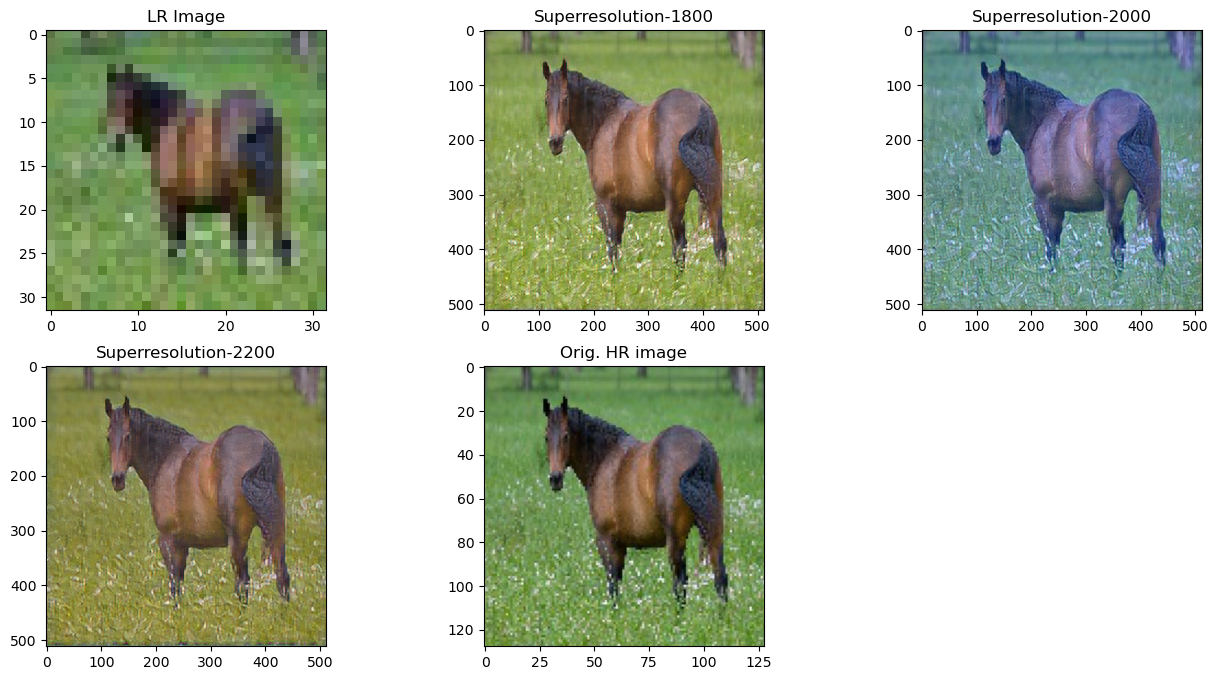

In [37]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator1 = load_model('/Users/akshat/GAN/models/g_14.h5', compile=False)
generator2 = load_model('/Users/akshat/GAN/models/g_15.h5', compile=False)
generator3 = load_model('/Users/akshat/GAN/models/g_16.h5', compile=False)

[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
print(ix)
# generate image from source
gen_image1 = generator1.predict(tar_image)
gen_image2 = generator2.predict(tar_image)
gen_image3 = generator3.predict(tar_image)

# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution-1800')
plt.imshow(gen_image1[0,:,:,:])
plt.subplot(233)
plt.title('Superresolution-2000')
plt.imshow(gen_image2[0,:,:,:])
plt.subplot(234)
plt.title('Superresolution-2200')
plt.imshow(gen_image3[0,:,:,:])
plt.subplot(235)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])
plt.show()


In [ ]:
from PIL import Image
from tensorflow.keras.models import load_model
import numpy as np
# Load and resize the input image
img = Image.open('/Users/akshat/Desktop/image processing/denoise_image.jpeg')
desired_size = (256,256)  # Replace with the desired dimensions
img = img.resize(desired_size)
img = np.array(img)
img = img / 255.0  # Normalize the image

g = load_model('/Users/akshat/GAN/models/g_15.h5', compile=False)


# Reshape the input image to match the expected shape of the generator model
img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])

# Generate the output image
g_img = g.predict(img)

plt.figure(figsize=(20, 20))
plt.subplot(231)
plt.title('orig')
plt.imshow(img[0,:,:,:])
plt.subplot(232)
plt.title('Superres')
plt.imshow(g_img[0,:,:,:])


In [23]:
from PIL import Image

# Assuming g_img is the generated image
generated_image = Image.fromarray(np.squeeze((g_img * 255).astype(np.uint8)))


# Save the generated image
generated_image.save("/Users/akshat/Desktop/image processing/gen_img.jpg")
